<a href="https://colab.research.google.com/github/bilalProgTech/btech-nmims/blob/master/NN-DL/Lab-Work/20230917-Lab-6-BTech-NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d shenba/time-series-datasets -f Electric_Production.csv

  0% 0.00/7.15k [00:00<?, ?B/s]
100% 7.15k/7.15k [00:00<00:00, 5.96MB/s]


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/content/Electric_Production.csv', index_col='DATE', parse_dates=True)

data.columns = ['Production']
data.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
data.tail()

,Production
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [ ]:
data.shape

(397, 1)

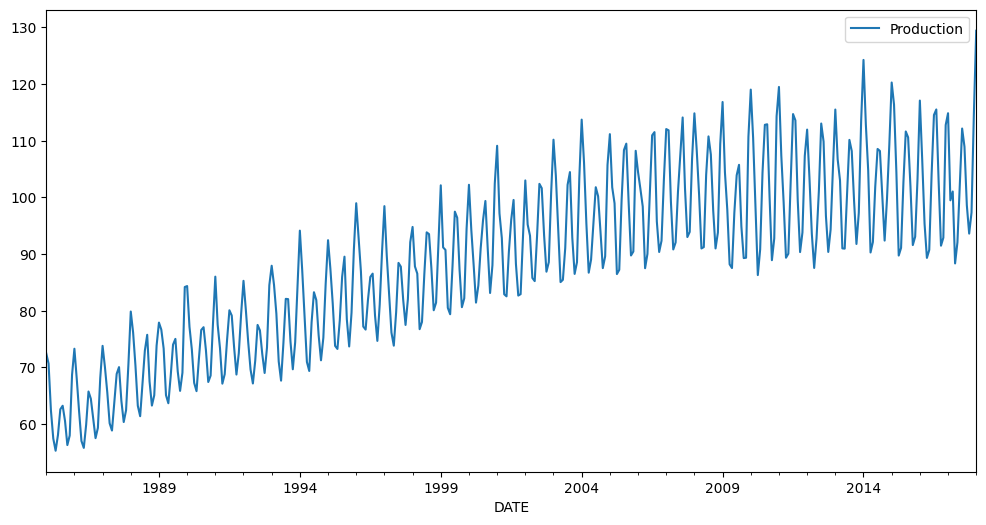

In [ ]:
data.plot(figsize=(12,6))
plt.show()

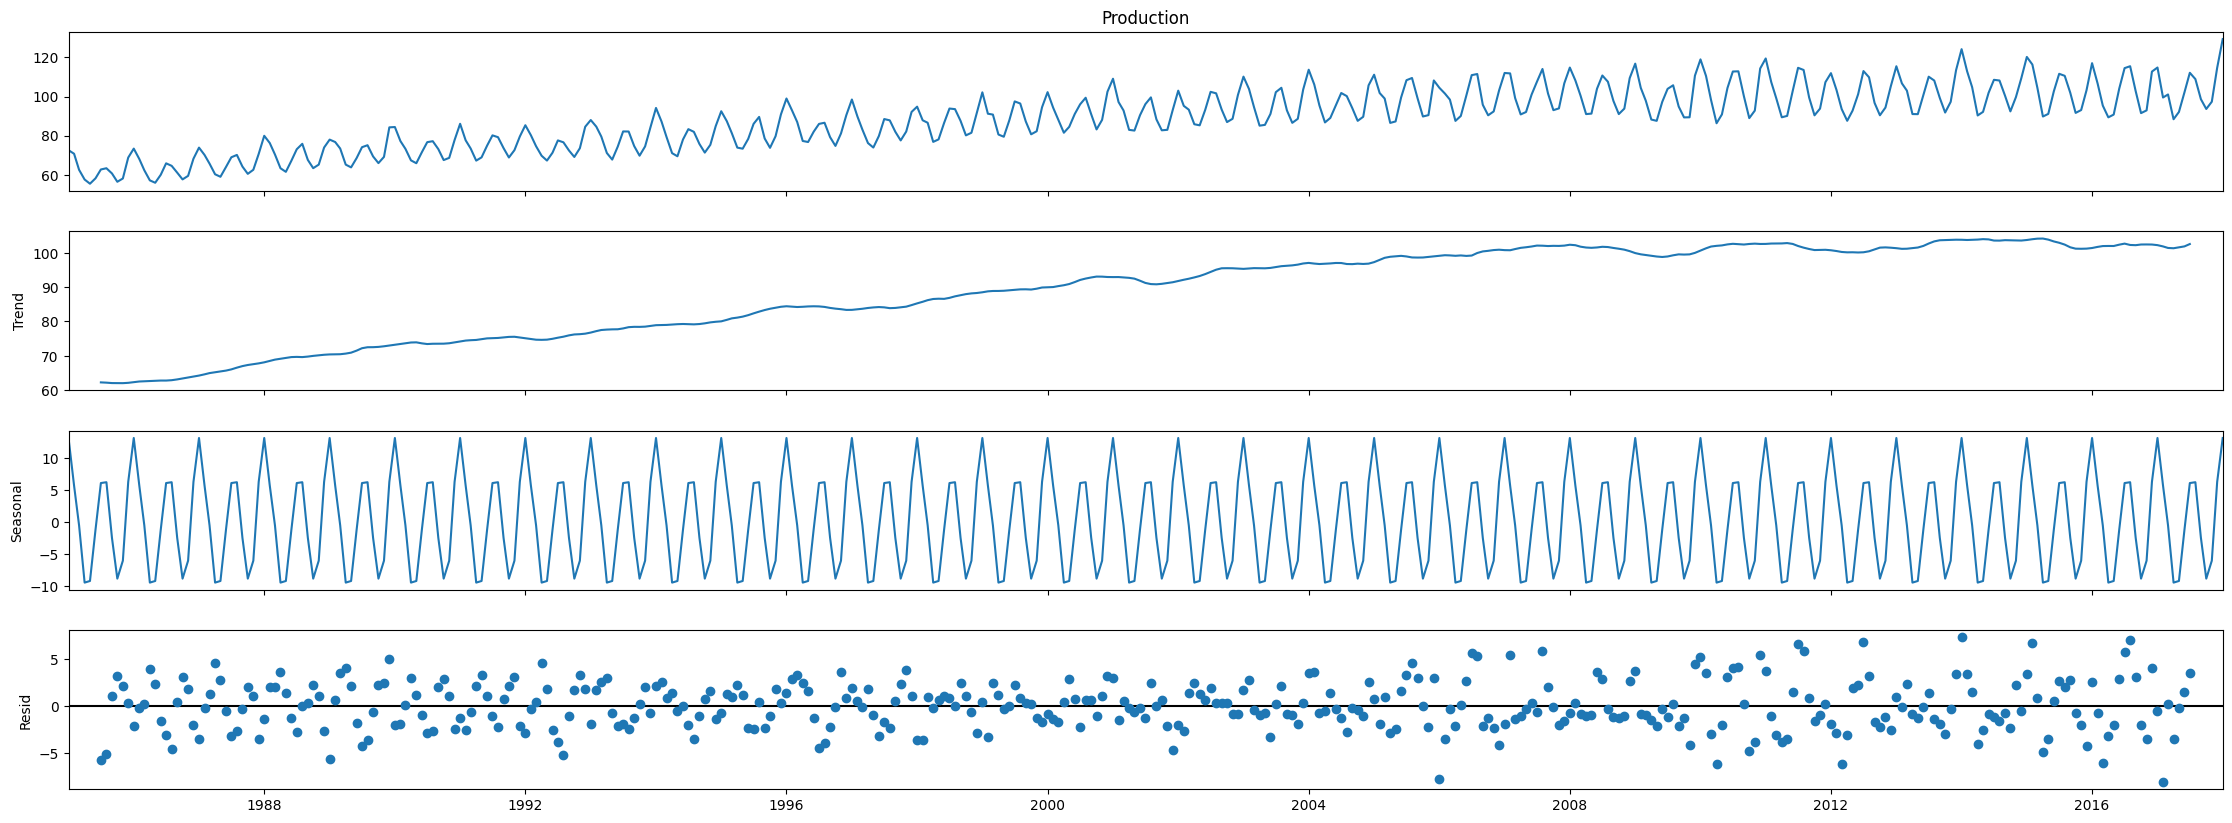

In [ ]:
results = seasonal_decompose(data['Production'])
fig = results.plot()
fig.set_size_inches((25, 9))
fig.show()

In [ ]:
train = data[:'2016-12-31']
test = data['2017-01-01':]
train.shape, test.shape

((384, 1), (13, 1))

# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


!pip install pmdarima

In [ ]:
import pmdarima as pm
arima_model = pm.auto_arima(train['Production'])
print("Best ARIMA Model order for Production: ",arima_model.order)
pred_next = np.round(arima_model.predict(test.shape[0]))

Best ARIMA Model order for Production:  (2, 1, 5)


In [ ]:
test['ARIMAPredictionProduction'] = pred_next
test.head()

<ipython-input-11-be1b2030ef9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMAPredictionProduction'] = pred_next


,Production,ARIMAPredictionProduction
DATE,,
2017-01-01,114.8505,120.0
2017-02-01,99.4901,115.0
2017-03-01,101.0396,102.0
2017-04-01,88.3530,94.0
2017-05-01,92.0805,96.0


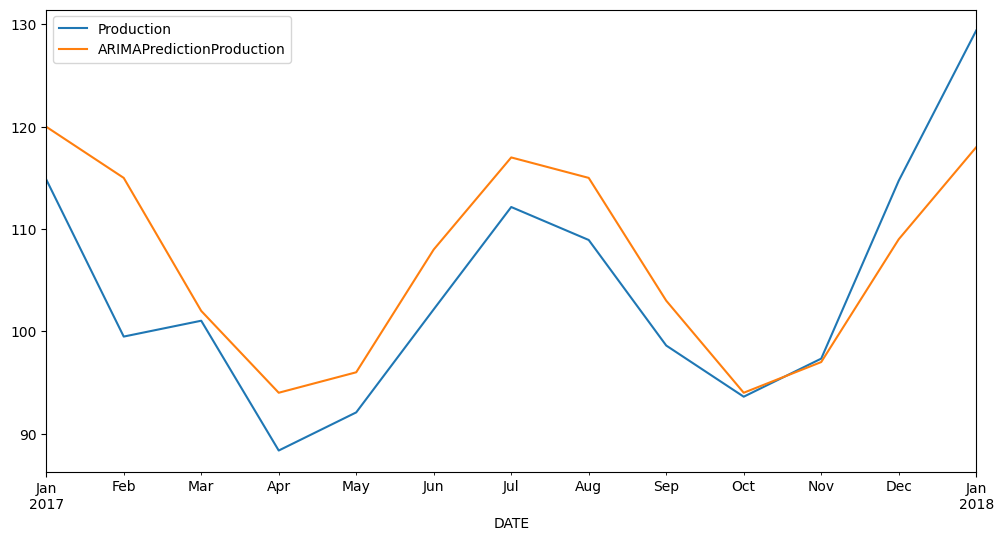

In [ ]:
test.plot(figsize=(12,6))
plt.show()

In [ ]:
np.sqrt(mean_squared_error(test['Production'],test['ARIMAPredictionProduction']))

6.748431327296053

# LSTM

In [ ]:
test = test.drop(['ARIMAPredictionProduction'], axis=1)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.24934943],
       [0.22275812],
       [0.10349754],
       [0.03127801],
       [0.        ],
       [0.04025686],
       [0.10596346],
       [0.11507721],
       [0.07643625],
       [0.01450976]])

In [ ]:
n_months = 12
n_features = train.shape[1]
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

In [ ]:
generator[0]

(array([[[0.24934943],
         [0.22275812],
         [0.10349754],
         [0.03127801],
         [0.        ],
         [0.04025686],
         [0.10596346],
         [0.11507721],
         [0.07643625],
         [0.01450976],
         [0.03895283],
         [0.19436378]]]),
 array([[0.26096101]]))

In [ ]:
generator[1]

(array([[[0.22275812],
         [0.10349754],
         [0.03127801],
         [0.        ],
         [0.04025686],
         [0.10596346],
         [0.11507721],
         [0.07643625],
         [0.01450976],
         [0.03895283],
         [0.19436378],
         [0.26096101]]]),
 array([[0.18380964]]))

In [ ]:
generator[1][0].shape

(1, 12, 1)

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_months, n_features)),
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(generator, epochs=10)

Epoch 1/10
372/372 [==============================] - 11s 19ms/step - loss: 0.0224
Epoch 2/10
372/372 [==============================] - 6s 15ms/step - loss: 0.0167
Epoch 3/10
372/372 [==============================] - 8s 21ms/step - loss: 0.0156
Epoch 4/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0154
Epoch 5/10
372/372 [==============================] - 6s 16ms/step - loss: 0.0135
Epoch 6/10
372/372 [==============================] - 7s 17ms/step - loss: 0.0114
Epoch 7/10
372/372 [==============================] - 7s 18ms/step - loss: 0.0106
Epoch 8/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0085
Epoch 9/10
372/372 [==============================] - 7s 20ms/step - loss: 0.0067
Epoch 10/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0061


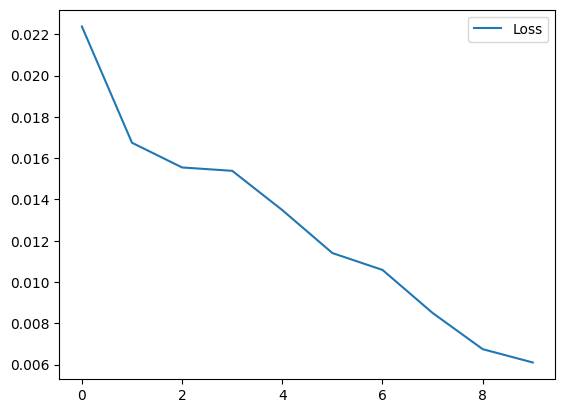

In [ ]:
plt.plot(range(10), history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [ ]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, n_features))
model.predict(temp)

1/1 [==============================] - 2s 2s/step


array([[0.84480363]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.86358533])

In [ ]:
test_predictions = []

last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [ ]:
test['PredictionProduction'] = scaler.inverse_transform(test_predictions)
test.head()

,Production,PredictionProduction
DATE,,
2017-01-01,114.8505,113.555693
2017-02-01,99.4901,105.840456
2017-03-01,101.0396,97.429379
2017-04-01,88.3530,93.795131
2017-05-01,92.0805,97.885969


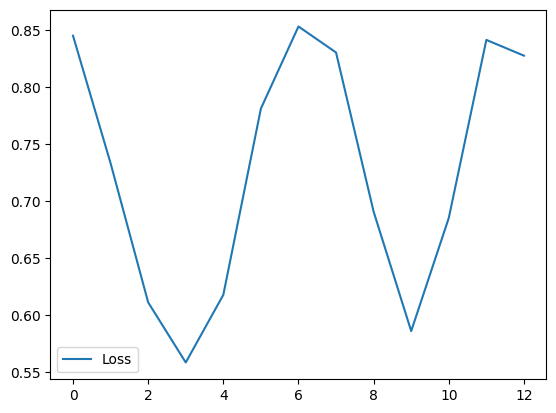

In [ ]:
plt.plot(range(len(test)), test_predictions, label='Loss')
plt.legend()
plt.show()

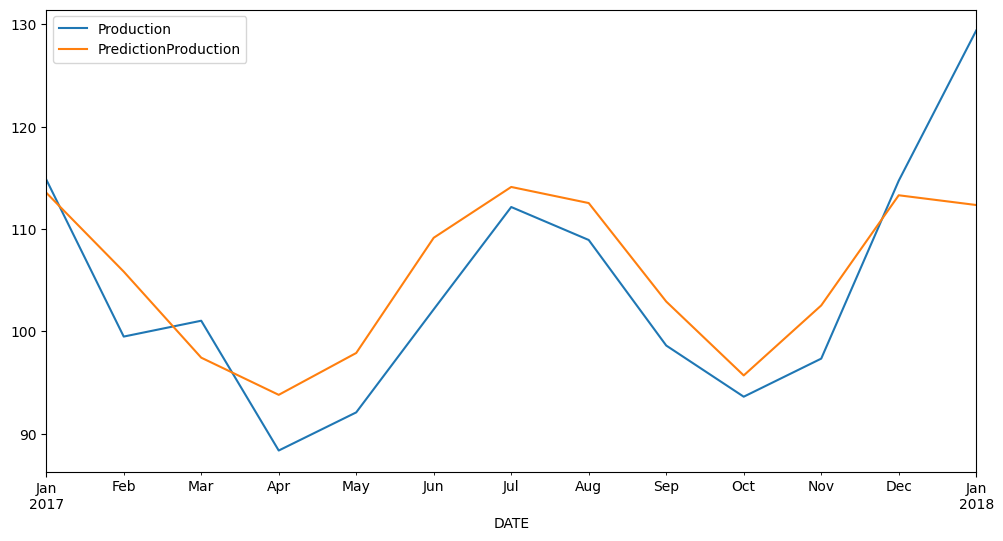

In [ ]:
test.plot(figsize=(12,6))
plt.show()

In [ ]:
np.sqrt(mean_squared_error(test['Production'],test['PredictionProduction']))

6.366291144029999